In [1]:
from Bio import SeqIO
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def get_kmers(seq, K=30):
    start = 0
    end   = len(seq)
    kmers = list()
    ranges= list()
    for i in range(start, end):
        if i > len(seq)-K or ((i+K)>len(seq)):
            break
        else:
            kmers.append(seq[i:i+K])
            ranges.append(f"{i}_{i+K}")
    return kmers, ranges

uniprots = ["P04637", "P02686", "P07305", "O00488"]
unip = 0

fastafile = f"/data/franco/datasets/disprot/fasta/{uniprots[unip]}.fasta"
K = 50
for record in SeqIO.parse(fastafile, "fasta"):
    seq = record.seq
    print(len(seq))
    kmers, ranges = get_kmers(seq, K=K)
    break

393


In [2]:
# Load disprot annotations
disprot_dir = "/data/franco/datasets/disprot/"
disprot_json_file = os.path.join(disprot_dir, "DisProt_release_2022_06_with_ambiguous_evidences.json")
with open(disprot_json_file) as infmt:
    json_dict = json.load(infmt)

target_unip = uniprots[unip]

def get_disprot_annots(target_unip, json_dict):
    found_dict = None
    for i in range(len(json_dict['data'])):
        if json_dict['data'][i]["acc"] == target_unip:
            found_dict = json_dict['data'][i]
            break
    disprot_regions = list()
    pfam_domains    = list()
    for region in found_dict['disprot_consensus']['full']:
        if region['type'] in ['T', 'D']:
            disprot_regions.append(region)
    if 'pfam' in found_dict['features']:
        for domain in found_dict['features']['pfam']:
            pfam_domains.append(domain)
    return disprot_regions, pfam_domains

disprot_regions, pfam_domains = get_disprot_annots(target_unip, json_dict)

In [3]:
print(disprot_regions)
print(pfam_domains)

[{'start': 1, 'end': 62, 'type': 'T'}, {'start': 63, 'end': 93, 'type': 'D'}, {'start': 291, 'end': 312, 'type': 'D'}, {'start': 361, 'end': 365, 'type': 'D'}, {'start': 366, 'end': 388, 'type': 'T'}, {'start': 389, 'end': 393, 'type': 'D'}]
[{'start': 100, 'end': 288, 'id': 'PF00870', 'name': 'p53, DNA-binding domain'}, {'start': 319, 'end': 357, 'id': 'PF07710', 'name': 'p53, tetramerisation domain'}, {'start': 35, 'end': 59, 'id': 'PF18521', 'name': 'Cellular tumor antigen p53, transactivation domain 2'}, {'start': 6, 'end': 30, 'id': 'PF08563', 'name': 'p53 transactivation domain'}]


In [4]:
kmers_file = f"{uniprots[unip]}_kmers{K}.fasta"
if not os.path.exists(kmers_file):
    with open(kmers_file, 'w') as outstream:
        for kmer, pos in zip(kmers, ranges):
            print(pos, kmer)
            #print(f">{uniprots[0]}_{pos}")
            outstream.write(f">{uniprots[unip]}_{pos}\n")
            outstream.write(f"{kmer}\n")

In [5]:
cmd = f"python calc_embeddings.py --model halft5 --fasta {kmers_file} --outdir {uniprots[unip]}_kmers{K}"
print(cmd)
os.system(cmd)

python calc_embeddings.py --model halft5 --fasta P04637_kmers50.fasta --outdir P04637_kmers50
working on P04637_0_50
File exists: P04637_kmers50/halft5/P04637_0_50.gz
working on P04637_1_51
File exists: P04637_kmers50/halft5/P04637_1_51.gz
working on P04637_2_52
File exists: P04637_kmers50/halft5/P04637_2_52.gz
working on P04637_3_53
File exists: P04637_kmers50/halft5/P04637_3_53.gz
working on P04637_4_54
File exists: P04637_kmers50/halft5/P04637_4_54.gz
working on P04637_5_55
File exists: P04637_kmers50/halft5/P04637_5_55.gz
working on P04637_6_56
File exists: P04637_kmers50/halft5/P04637_6_56.gz
working on P04637_7_57
File exists: P04637_kmers50/halft5/P04637_7_57.gz
working on P04637_8_58
File exists: P04637_kmers50/halft5/P04637_8_58.gz
working on P04637_9_59
File exists: P04637_kmers50/halft5/P04637_9_59.gz
working on P04637_10_60
File exists: P04637_kmers50/halft5/P04637_10_60.gz
working on P04637_11_61
File exists: P04637_kmers50/halft5/P04637_11_61.gz
working on P04637_12_62
Fi

0

In [6]:
# Load the calculated embeddings
embeddir = f"{uniprots[unip]}_kmers{K}/halft5"
filelist = os.listdir(embeddir)
embeddings = list()
for i in range(len(filelist)):
    filename = f"{uniprots[unip]}_{0+i}_{K+i}.gz"
    filepath = os.path.join(embeddir, filename)
    embedding = np.loadtxt(filepath)
    embeddings.append(embedding)

In [7]:
orig_embedding = np.loadtxt(f"/data/franco/datasets/prot_embedding_weights/disprot/halft5/{uniprots[unip]}.gz")

In [8]:
orig_embedding.shape

(393, 1024)

In [9]:
from scipy.spatial import distance

def get_cosdist(u, v):
    values = list()
    if u.shape[0] == v.shape[0]:
        for i in range(u.shape[0]):
            values.append(distance.cosine(u[i,:], v[i,:]))
    return values

cos_distances = list()
for i,r in enumerate(ranges):
    arr = r.split("_")
    s   = int(arr[0])
    e   = int(arr[1])
    cut_kmer  = orig_embedding[s:e,:]
    orig_kmer = embeddings[i]
    # print(cut_kmer.shape, orig_kmer.shape)
    cos_dist = get_cosdist(cut_kmer, orig_kmer)
#     cos_dist = get_cosdist(cut_kmer, cut_kmer)
    cos_distances.append(cos_dist)

In [10]:
image_matrix = np.zeros((len(cos_distances), len(seq)))
for i,r in enumerate(ranges):
    arr = r.split("_")
    s   = int(arr[0])
    e   = int(arr[1])
    image_matrix[i, s:e] = cos_distances[i]

393


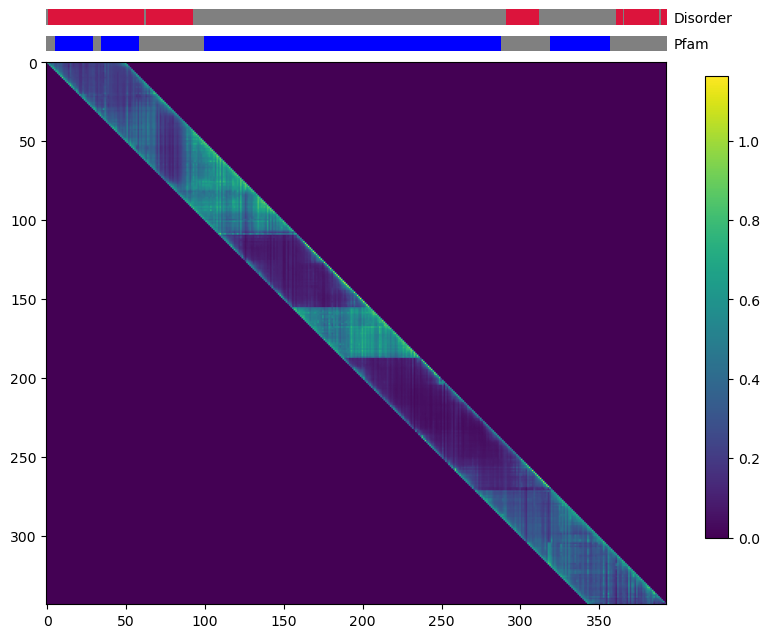

In [66]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap

domain_cmap_list = ['gray', 'blue'] #, 'gold', 'lawngreen', 'blue', 'grey']
domain_cmap = ListedColormap(domain_cmap_list)
disorder_cmap_list = ['gray', 'crimson'] #, 'gold', 'lawngreen', 'blue', 'grey']
disorder_cmap = ListedColormap(disorder_cmap_list)

print(len(seq))
fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111)
im  = ax.imshow(image_matrix)
fig.colorbar(im, ax=ax, shrink=0.6)
# fig.suptitle(f"{uniprots[unip]} {K}-mer embedding cos-distance")

# Add annotations
divider = make_axes_locatable(ax)

domain_colors = np.zeros(len(seq))
for d in pfam_domains:
    domain_colors[d['start']:d['end']] = 1
    
pfam_regioncolors = np.zeros((len(seq), int(image_matrix.shape[0]*0.03) ))
for i,x in enumerate(domain_colors):
    pfam_regioncolors[i, :] = x

# add domain annotation on top
cax_domaincolors = divider.append_axes("top", size="3%", pad= 0.1)
cax_domaincolors.set_axis_off()
ccol = cax_domaincolors.imshow(pfam_regioncolors.T, cmap=domain_cmap)

# add disorder annotations
disorder_colors = np.zeros(len(seq))
for d in disprot_regions:
    disorder_colors[d['start']:d['end']] = 1
disorder_regioncolors = np.zeros((len(seq), int(image_matrix.shape[0]*0.03) ))
for i,x in enumerate(disorder_colors):
    disorder_regioncolors[i, :] = x
    
cax_disordercolors = divider.append_axes("top", size="3%", pad= 0.1)
cax_disordercolors.set_axis_off()
disccol = cax_disordercolors.imshow(disorder_regioncolors.T, cmap=disorder_cmap)

bbox_points = plt.gcf().transFigure.inverted().transform(cax_disordercolors.get_tightbbox(fig.canvas.get_renderer()).get_points())
label_xpoint = bbox_points[1,0] + 0.01*bbox_points[1,0]
label_ypoint = bbox_points[0,1] #+ (bbox_points[1,1]-bbox_points[1,0])
ax.text(label_xpoint, label_ypoint, "Disorder", va='bottom', ha='left', transform=plt.gcf().transFigure)

bbox_points = plt.gcf().transFigure.inverted().transform(cax_domaincolors.get_tightbbox(fig.canvas.get_renderer()).get_points())
label_xpoint = bbox_points[1,0] + 0.01*bbox_points[1,0]
label_ypoint = bbox_points[0,1] #+ (bbox_points[1,1]-bbox_points[1,0])
ax.text(label_xpoint, label_ypoint, "Pfam", va='bottom', ha='left', transform=plt.gcf().transFigure)


# plt.savefig(f"{uniprots[unip]}_{K}mer_cosdist.png", bbox_inches='tight')
plt.show()

In [67]:
reformat_aakmer_embeds = list()
aa_concatseq = list()
for i in range(len(seq)):
    aa_concatseq.append(seq[i])
    reformat_aakmer_embeds.append(orig_embedding[i,:])
    
counter = len(seq)
row_seqpos = dict()
row_kmer   = dict()
for i in range(len(seq)):
    for j in range(K):
        if j <= i and ((i-j) <= (len(seq)-K)):
            #print(f"seqpos {i}, kmer {i-j}, kpos {j}")
            reformat_aakmer_embeds.append(embeddings[i-j][j])
            row_seqpos[counter] = i
            row_kmer[counter]   = i-j
            aa_concatseq.append(seq[i])
            counter += 1

In [68]:
np.array(reformat_aakmer_embeds).shape

(17593, 1024)

In [21]:
import umap

my_umap = umap.UMAP(n_neighbors=200, min_dist=.25)
# my_umap = umap.UMAP(n_neighbors=100, min_dist=.9)
umap_embedding = my_umap.fit_transform(np.array(reformat_aakmer_embeds))

In [22]:
umap_embedding.shape

(17593, 2)

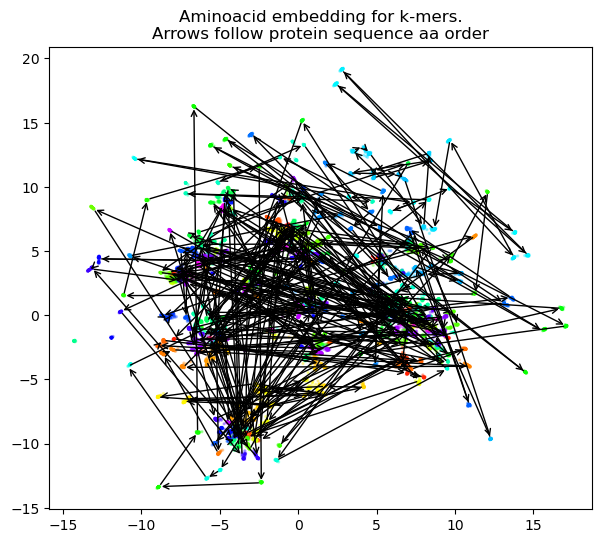

In [74]:
from matplotlib import cm
from matplotlib.patches import Patch

cmap = cm.get_cmap('gist_rainbow', len(seq))
seqpos = list(np.arange(len(seq))) + [row_seqpos[x] for x in np.arange(len(seq), umap_embedding.shape[0])]

fig = plt.figure(figsize=(7,6))
ax  = fig.add_subplot(111)

x = umap_embedding[0:len(seq),0]
y = umap_embedding[0:len(seq),1]

ax.scatter(x[0], y[0], marker='x', color='red')

for i in range(len(x)-1):
    ax.annotate("", xy=(x[i+1], y[i+1]), xycoords='data',
                    xytext=(x[i], y[i]), textcoords='data',
                    arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

ax.scatter(umap_embedding[:,0], umap_embedding[:,1], s=2, alpha=0.3,
           c=[cmap(x) for x in seqpos])
ax.set_title("Aminoacid embedding for k-mers.\nArrows follow protein sequence aa order")

plt.show()

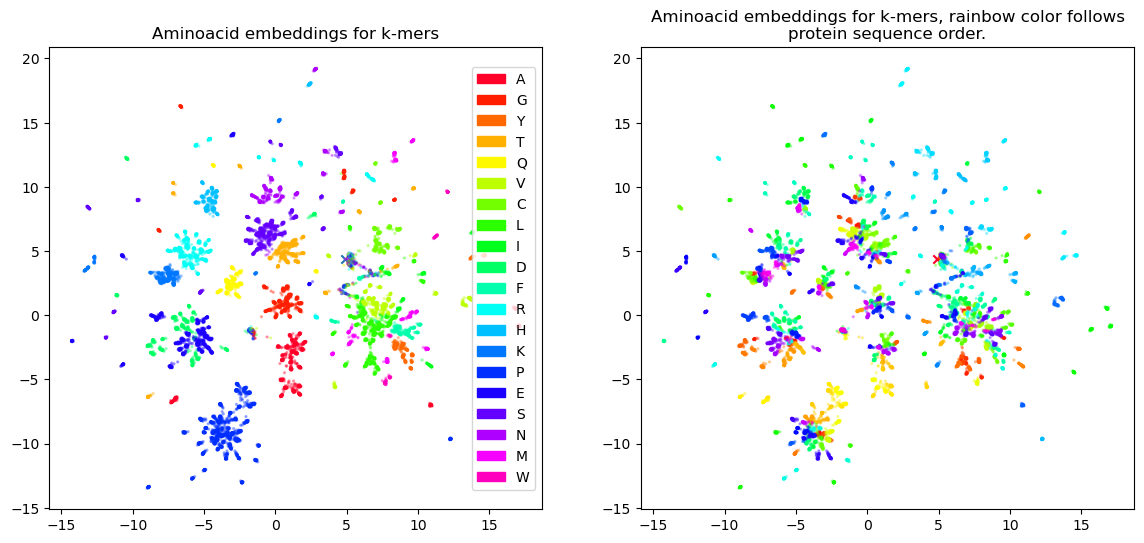

In [72]:
from matplotlib import cm
from matplotlib.patches import Patch

AAs = list(set(aa_concatseq))
cmapAA = cm.get_cmap('gist_rainbow', len(AAs))
colordictAA = dict(zip(AAs, np.arange(0, len(AAs))))

fig = plt.figure(figsize=(14,6))
ax1  = fig.add_subplot(121)
ax2  = fig.add_subplot(122)

x = umap_embedding[0:len(seq),0]
y = umap_embedding[0:len(seq),1]

ax1.scatter(x[0], y[0], marker='x')
ax1.scatter(umap_embedding[:,0], umap_embedding[:,1], s=2, alpha=0.3,
           c=[cmapAA(colordictAA[x]) for x in aa_concatseq])

legend_elements = [Patch(facecolor=cmapAA(colordictAA[x]), edgecolor=cmapAA(colordictAA[x]),label=x) for x in AAs]
ax1.legend(handles=legend_elements, loc='right')

cmap = cm.get_cmap('gist_rainbow', len(seq))
seqpos = list(np.arange(len(seq))) + [row_seqpos[x] for x in np.arange(len(seq), umap_embedding.shape[0])]
ax2.scatter(x[0], y[0], marker='x', color=cmap(seqpos[0]))
ax2.scatter(umap_embedding[:,0], umap_embedding[:,1], s=2, alpha=0.3,
            c=[cmap(x) for x in seqpos])

ax1.set_title("Aminoacid embeddings for k-mers")
ax2.set_title("Aminoacid embeddings for k-mers, rainbow color follows\nprotein sequence order.")
plt.show()

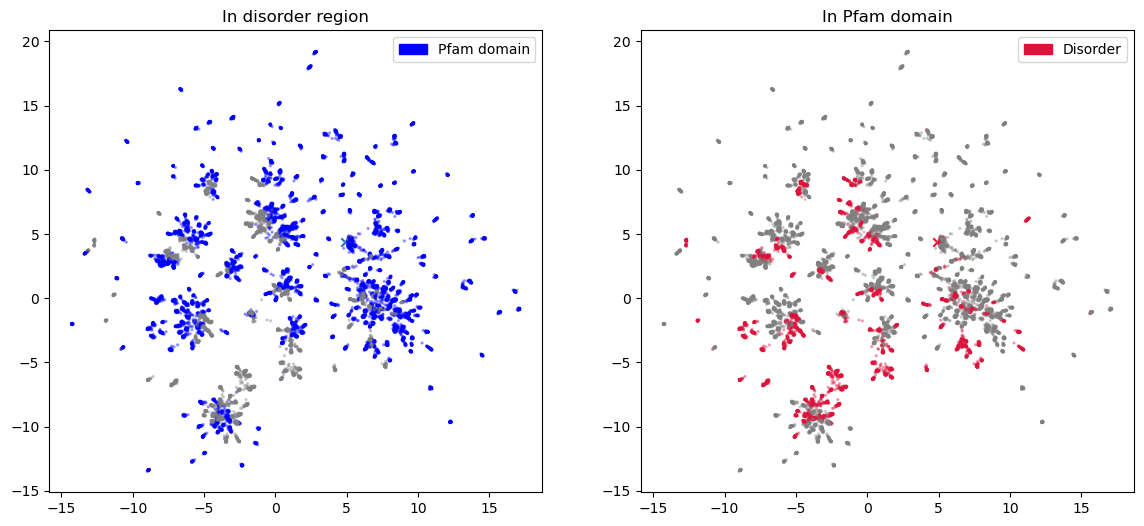

In [93]:
from matplotlib import cm
from matplotlib.patches import Patch

AAs = list(set(aa_concatseq))
cmapAA = cm.get_cmap('gist_rainbow', len(AAs))
colordictAA = dict(zip(AAs, np.arange(0, len(AAs))))

fig = plt.figure(figsize=(14,6))
ax1  = fig.add_subplot(121)
ax2  = fig.add_subplot(122)

x = umap_embedding[0:len(seq),0]
y = umap_embedding[0:len(seq),1]

Dcolors = [domain_cmap(x) for x in range(len(seq))] + [domain_cmap(domain_colors[row_seqpos[x]]) for x in range(len(seq),umap_embedding.shape[0])]
ax1.scatter(x[0], y[0], marker='x')
ax1.scatter(umap_embedding[:,0], umap_embedding[:,1], s=2, alpha=0.3,
           c=Dcolors)

legend_elements = [Patch(facecolor=domain_cmap(1), edgecolor=domain_cmap(1),label="Pfam domain") ]
ax1.legend(handles=legend_elements, loc='upper right')

dcolors = [disorder_cmap(x) for x in range(len(seq))] + [disorder_cmap(disorder_colors[row_seqpos[x]]) for x in range(len(seq),umap_embedding.shape[0])]
seqpos = list(np.arange(len(seq))) + [row_seqpos[x] for x in np.arange(len(seq), umap_embedding.shape[0])]
ax2.scatter(x[0], y[0], marker='x', color=cmap(seqpos[0]))
ax2.scatter(umap_embedding[:,0], umap_embedding[:,1], s=2, alpha=0.3,
            c=dcolors)

legend_elements = [Patch(facecolor=disorder_cmap(1), edgecolor=disorder_cmap(1),label="Disorder") ]
ax2.legend(handles=legend_elements, loc='upper right')

ax1.set_title("In Pfam domain")
ax2.set_title("In disorder region")
plt.show()

In [88]:
row_seqpos[395]

1